In [141]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import shutil

# Description
This notebook decompresses the csrs-ppp outputs and reads calculated ZWD from .tro files.

## Directry structure
### Before decompression
> PPP_result_2024/
>> rov_20240401.obs_full_output.zip\
>> rov_20240402.obs_full_output.zip\
>> rov_20240403.obs_full_output.zip\
>> rov_20240501.obs_full_output.zip, ...

### After decompression
> PPP_result_2024/
>> 202404/
>>> rov_20240401.clk\
>>> rov_20240401.csv\
>>> rov_20240401.pdf\
>>> rov_20240401.pos\
>>> rov_20240401.sum\
>>> rov_20240401.tro\
>>> rov_20240402.clk\
>>> rov_20240402.csv\
>>> rov_20240402.pdf\
>>> rov_20240402.pos\
>>> rov_20240402.sum\
>>> rov_20240402.tro, ...

>> 202405/
>>> rov_20240501.clk\
>>> rov_20240501.csv\
>>> rov_20240501.pdf\
>>> rov_20240501.pos\
>>> rov_20240501.sum\
>>> rov_20240501.tro, ...

## Decompress zip folders of csrs-ppp results

In [132]:
csrsdir = '/mnt/AKLabNAS/jsugiyama/SA_GNSS_data/PPP_result_2024'
#mdirs = [d for d in os.listdir(csrsdir) if ".zip" in d]
mdirs = [d for d in os.listdir(csrsdir) if "rov_202303" in d]
mdirs.sort()
# decompress zip folders
for m in mdirs:
    zip_path = os.path.join(csrsdir, m)
    out_dir = os.path.join(csrsdir, m[4:10])
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    shutil.unpack_archive(zip_path, out_dir)
    # remove the zip folder
    os.remove(zip_path)



## Read zenith wet delay from .tro files
This cell reads .tro files and calculates zwd per minutes.

In [134]:
csrsdir = '/mnt/AKLabNAS/jsugiyama/SA_GNSS_data/PPP_result_2024'
mdirs = []
start_folder = 202401
end_folder = 202405
for i in range(start_folder, end_folder+1):
    mdirs.append(os.path.join(csrsdir, str(i)))
tro_data = []
for mdir in mdirs:
    mpath = os.path.join(csrsdir, mdir)
    #print(mpath)
    trofiles = [f for f in os.listdir(mpath) if f.endswith('.tro')]
    trofiles.sort()
    for trofile in trofiles:
        tropath = os.path.join(mpath, trofile)
        #print(tropath)
        with open(tropath, 'rt') as f:
            lines = f.readlines()

        count = 0

        tro_data_minute = []
        for line in lines:
            if line.find('ROV_') < 0:
                continue
            if line.startswith('%'):
                continue
            linesp = line.split()
            if len(linesp) != 9:
                continue

            count += 1
            if count==1:
                continue

            epoch = linesp[1]
            t = datetime.datetime.strptime(epoch[:6], '%y:%j')
            delta = datetime.timedelta(seconds=int(epoch[7:]))
            t = t + delta

            if len(tro_data_minute)>0:
                t0 = tro_data_minute[0][0]
                if t0.minute != t.minute:
                    tro_data_minute = np.array(tro_data_minute)
                    data_mean = np.mean(tro_data_minute[:,1:], axis=0)
                    tro_data.append([t0, data_mean])
                    tro_data_minute = []
            
            ztdd = float(linesp[2])
            ztdw = float(linesp[3])
            ztdw_std = float(linesp[4])
            #tgntot = float(linesp[5])
            #tgntot_std = float(linesp[6])
            #tgetot = float(linesp[7])
            #tgetot_std = float(linesp[8])
        
            tro_data_minute.append([t, ztdd, ztdw, ztdw_std])
        if len(tro_data_minute)>10:
            tro_data_minute = np.array(tro_data_minute)
            data_mean = np.mean(tro_data_minute[:,1:], axis=0)
            tro_data.append([t0, data_mean])

In [136]:
timestamps = np.array(tro_data).T[0]
zwd = []
for d in np.array(tro_data).T[1]:
    zwd.append(d[1])
zwd = np.array(zwd)

/tmp/ipykernel_26857/151169912.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timestamps = np.array(tro_data).T[0]
/tmp/ipykernel_26857/151169912.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for d in np.array(tro_data).T[1]:


(array([19723., 19737., 19754., 19768., 19783., 19797., 19814., 19828.,
        19844., 19858.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

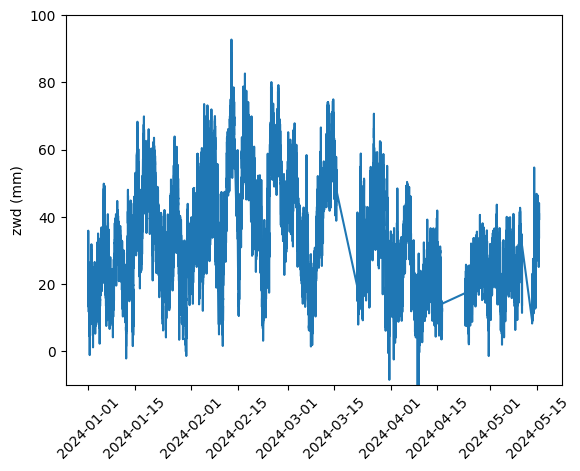

In [140]:
plt.figure()
plt.plot(timestamps, zwd)
plt.ylim(-10, 100)
plt.ylabel("zwd (mm)")
plt.xticks(rotation=45)